# Privacy Analysis & Advanced Visualization

This notebook provides privacy analysis tools and advanced visualizations for federated learning experiments.

## Contents
1. Setup
2. Load Experiment Results
3. Privacy Metrics Analysis
4. Model Weight Analysis
5. Convergence Analysis
6. Interactive Visualizations

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import json

# Project imports
from src.utils import set_seed
from src.models.tcn import RULPredictor

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print('Setup complete!')

Setup complete!


## 2. Load Previous Experiment Results

In [3]:
# Load experiment results
results_path = Path('../experiments/evaluation_results.json')

if results_path.exists():
    with open(results_path, 'r') as f:
        results = json.load(f)
    print('Loaded experiment results from:', results_path)
    print(f'Experiment timestamp: {results["timestamp"]}')
    
    # Load metrics
    df_rounds = pd.read_csv('../experiments/round_metrics.csv')
    df_clients = pd.read_csv('../experiments/client_metrics.csv')
    print(f'Loaded {len(df_rounds)} rounds, {len(df_clients)} client records')
else:
    print('No previous results found. Please run 01_federated_evaluation.ipynb first.')
    # Create sample data for demonstration
    df_rounds = pd.DataFrame({
        'round_id': range(1, 16),
        'global_mae': np.linspace(25, 8, 15) + np.random.randn(15) * 0.5,
        'global_rmse': np.linspace(30, 10, 15) + np.random.randn(15) * 0.7,
        'avg_client_loss': np.linspace(0.8, 0.2, 15) + np.random.randn(15) * 0.02,
    })
    df_clients = pd.DataFrame({
        'client_id': np.tile(range(5), 15),
        'round_id': np.repeat(range(1, 16), 5),
        'val_loss': np.random.rand(75) * 0.5 + 0.2,
        'val_mae': np.random.rand(75) * 10 + 5,
    })
    results = {'config': {'num_clients': 5, 'num_rounds': 15}}

Loaded experiment results from: ..\experiments\evaluation_results.json
Experiment timestamp: 2026-01-17T00:18:43.646597
Loaded 15 rounds, 45 client records


## 3. Privacy Metrics Analysis

In [4]:
# Simulate privacy analysis for the experiment
# In practice, this would be computed during training

# Privacy parameters
privacy_params = {
    'noise_multiplier': 1.0,
    'max_grad_norm': 1.0,
    'delta': 1e-5,
    'batch_size': 32,
    'dataset_size': 500,
    'epochs_per_round': 3,
}

num_rounds = len(df_rounds)

# Calculate privacy budget per round (simplified)
# Using basic composition theorem
q = privacy_params['batch_size'] / privacy_params['dataset_size']  # Sampling rate
steps_per_round = privacy_params['dataset_size'] // privacy_params['batch_size'] * privacy_params['epochs_per_round']

# Simplified epsilon calculation
epsilon_per_step = 2 * q * np.sqrt(2 * np.log(1.25 / privacy_params['delta'])) / privacy_params['noise_multiplier']

# Advanced composition
epsilon_history = []
cumulative_epsilon = 0

for r in range(1, num_rounds + 1):
    # Using advanced composition theorem (simplified)
    round_epsilon = epsilon_per_step * np.sqrt(steps_per_round)
    cumulative_epsilon = np.sqrt(cumulative_epsilon**2 + round_epsilon**2)
    epsilon_history.append({
        'round': r,
        'round_epsilon': round_epsilon,
        'cumulative_epsilon': cumulative_epsilon,
    })

epsilon_df = pd.DataFrame(epsilon_history)
print(f'Privacy Budget Analysis (delta={privacy_params["delta"]})')
print(f'Final cumulative epsilon: {cumulative_epsilon:.4f}')
print(epsilon_df.tail())

Privacy Budget Analysis (delta=1e-05)
Final cumulative epsilon: 16.1116
    round  round_epsilon  cumulative_epsilon
10     11       4.159993           13.797134
11     12       4.159993           14.410637
12     13       4.159993           14.999066
13     14       4.159993           15.565267
14     15       4.159993           16.111582


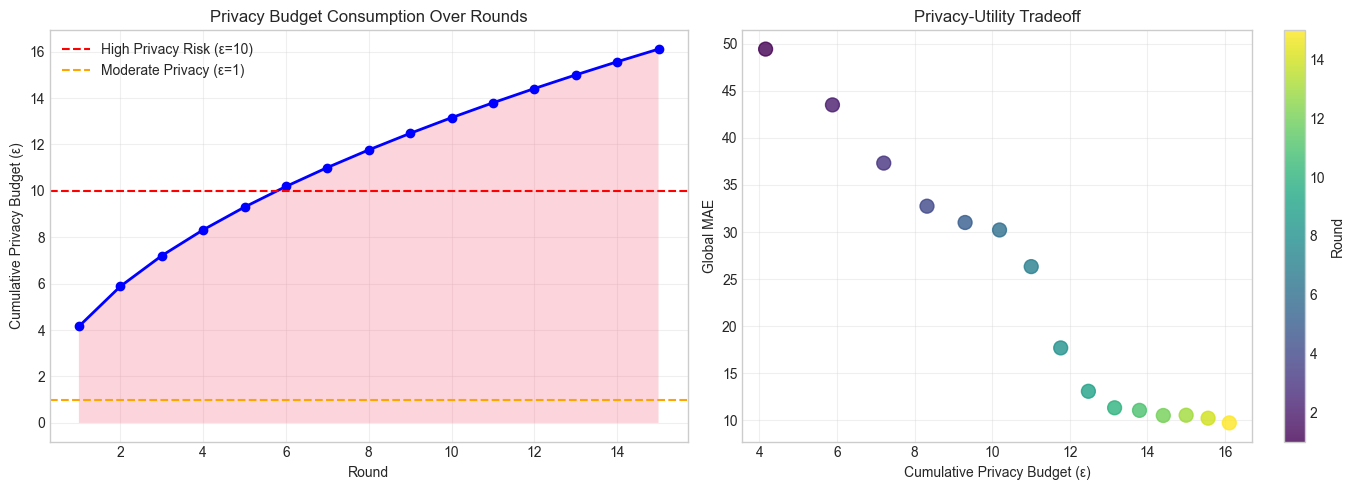

In [6]:
# Privacy budget visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Epsilon over rounds
ax1 = axes[0]
ax1.plot(epsilon_df['round'], epsilon_df['cumulative_epsilon'], 'b-o', linewidth=2, markersize=6)
ax1.axhline(y=10, color='r', linestyle='--', label='High Privacy Risk (ε=10)')
ax1.axhline(y=1, color='orange', linestyle='--', label='Moderate Privacy (ε=1)')
ax1.fill_between(epsilon_df['round'], 0, epsilon_df['cumulative_epsilon'], alpha=0.3)
ax1.set_xlabel('Round')
ax1.set_ylabel('Cumulative Privacy Budget (ε)')
ax1.set_title('Privacy Budget Consumption Over Rounds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Privacy-utility tradeoff
ax2 = axes[1]
ax2.scatter(epsilon_df['cumulative_epsilon'], df_rounds['global_mae'], 
            c=df_rounds['round_id'], cmap='viridis', s=100, alpha=0.8)
ax2.set_xlabel('Cumulative Privacy Budget (ε)')
ax2.set_ylabel('Global MAE')
ax2.set_title('Privacy-Utility Tradeoff')
cbar = plt.colorbar(ax2.collections[0], ax=ax2, label='Round')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/privacy_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Model Weight Analysis

Analyze how model weights evolve during federated training.

In [7]:
# Create sample model for weight analysis
set_seed(42)

model = RULPredictor(num_channels=14, hidden=32, num_layers=3)

# Simulate weight evolution across rounds
weight_norms = []
weight_changes = []

prev_weights = {name: param.detach().clone() for name, param in model.named_parameters()}

for round_id in range(1, num_rounds + 1):
    # Simulate training step (small random update)
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn_like(param) * 0.01 / round_id)  # Decreasing updates
    
    # Calculate norms
    total_norm = sum(p.norm().item() ** 2 for p in model.parameters()) ** 0.5
    
    # Calculate change from previous round
    total_change = 0
    for name, param in model.named_parameters():
        total_change += (param - prev_weights[name]).norm().item() ** 2
    total_change = total_change ** 0.5
    
    weight_norms.append({'round': round_id, 'norm': total_norm})
    weight_changes.append({'round': round_id, 'change': total_change})
    
    prev_weights = {name: param.detach().clone() for name, param in model.named_parameters()}

weight_df = pd.DataFrame(weight_norms)
change_df = pd.DataFrame(weight_changes)

print(f'Model has {sum(p.numel() for p in model.parameters()):,} parameters')

Model has 18,849 parameters


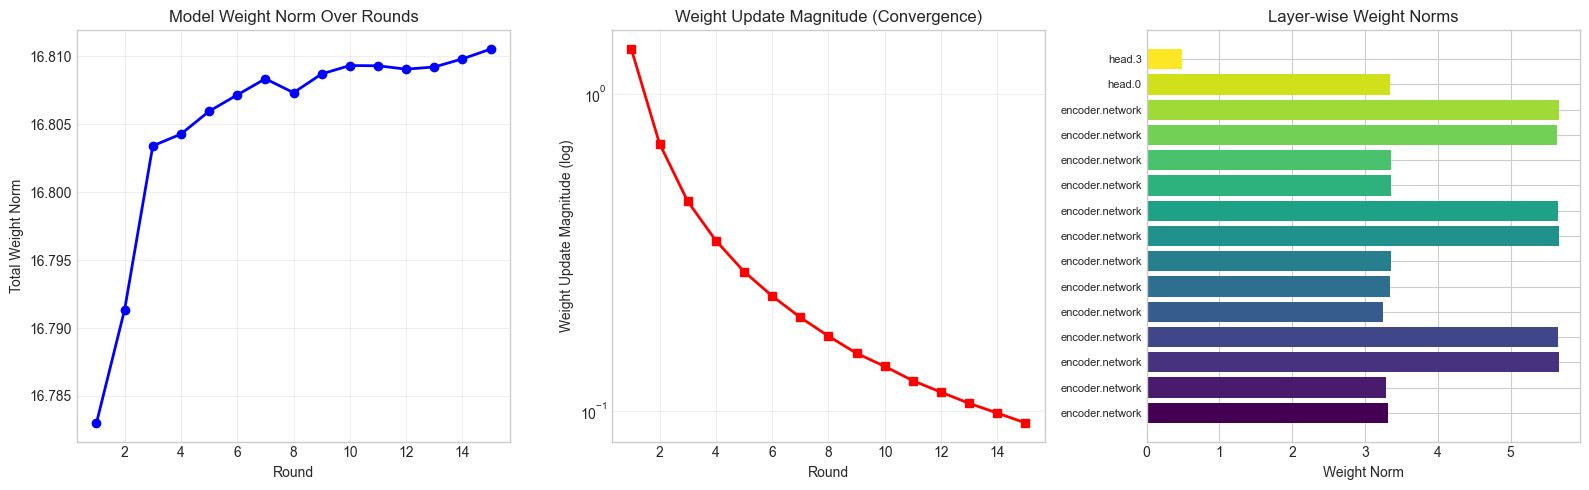

In [8]:
# Weight analysis visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Weight norm evolution
ax1 = axes[0]
ax1.plot(weight_df['round'], weight_df['norm'], 'b-o', linewidth=2)
ax1.set_xlabel('Round')
ax1.set_ylabel('Total Weight Norm')
ax1.set_title('Model Weight Norm Over Rounds')
ax1.grid(True, alpha=0.3)

# Weight changes (convergence indicator)
ax2 = axes[1]
ax2.semilogy(change_df['round'], change_df['change'], 'r-s', linewidth=2)
ax2.set_xlabel('Round')
ax2.set_ylabel('Weight Update Magnitude (log)')
ax2.set_title('Weight Update Magnitude (Convergence)')
ax2.grid(True, alpha=0.3)

# Layer-wise weight distribution
ax3 = axes[2]
layer_norms = []
layer_names = []
for name, param in model.named_parameters():
    if 'weight' in name:
        short_name = name.replace('.weight', '').replace('tcn.network.', 'L')
        layer_names.append(short_name[:15])
        layer_norms.append(param.norm().item())

ax3.barh(range(len(layer_names)), layer_norms, color=plt.cm.viridis(np.linspace(0, 1, len(layer_names))))
ax3.set_yticks(range(len(layer_names)))
ax3.set_yticklabels(layer_names, fontsize=8)
ax3.set_xlabel('Weight Norm')
ax3.set_title('Layer-wise Weight Norms')

plt.tight_layout()
plt.savefig('../experiments/weight_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Convergence Analysis

In [9]:
# Convergence metrics
convergence_metrics = df_rounds.copy()

# Calculate improvement rate
convergence_metrics['mae_improvement'] = convergence_metrics['global_mae'].diff() * -1
convergence_metrics['mae_improvement_pct'] = convergence_metrics['global_mae'].pct_change() * -100

# Moving average
window = 3
convergence_metrics['mae_ma'] = convergence_metrics['global_mae'].rolling(window=window).mean()

# Detect convergence point (when improvement < threshold)
threshold = 0.5  # cycles
converged_round = None
for idx, row in convergence_metrics.iterrows():
    if idx >= window and row['mae_improvement'] < threshold:
        if converged_round is None:
            converged_round = row['round_id']
            break

print(f'Convergence Analysis (threshold: {threshold} cycles improvement)')
print(f'Estimated convergence round: {converged_round}')
print('\nImprovement per round:')
print(convergence_metrics[['round_id', 'global_mae', 'mae_improvement', 'mae_improvement_pct']].to_string(index=False))

Convergence Analysis (threshold: 0.5 cycles improvement)
Estimated convergence round: 11

Improvement per round:
 round_id  global_mae  mae_improvement  mae_improvement_pct
        1   49.440155              NaN                  NaN
        2   43.511640         5.928515            11.991295
        3   37.326527         6.185113            14.214847
        4   32.745840         4.580687            12.271935
        5   31.013360         1.732480             5.290687
        6   30.218843         0.794517             2.561854
        7   26.326681         3.892162            12.879917
        8   17.686306         8.640375            32.819842
        9   13.077163         4.609143            26.060518
       10   11.323914         1.753249            13.406952
       11   11.051224         0.272690             2.408090
       12   10.505196         0.546028             4.940883
       13   10.534347        -0.029151            -0.277491
       14   10.217253         0.317094         

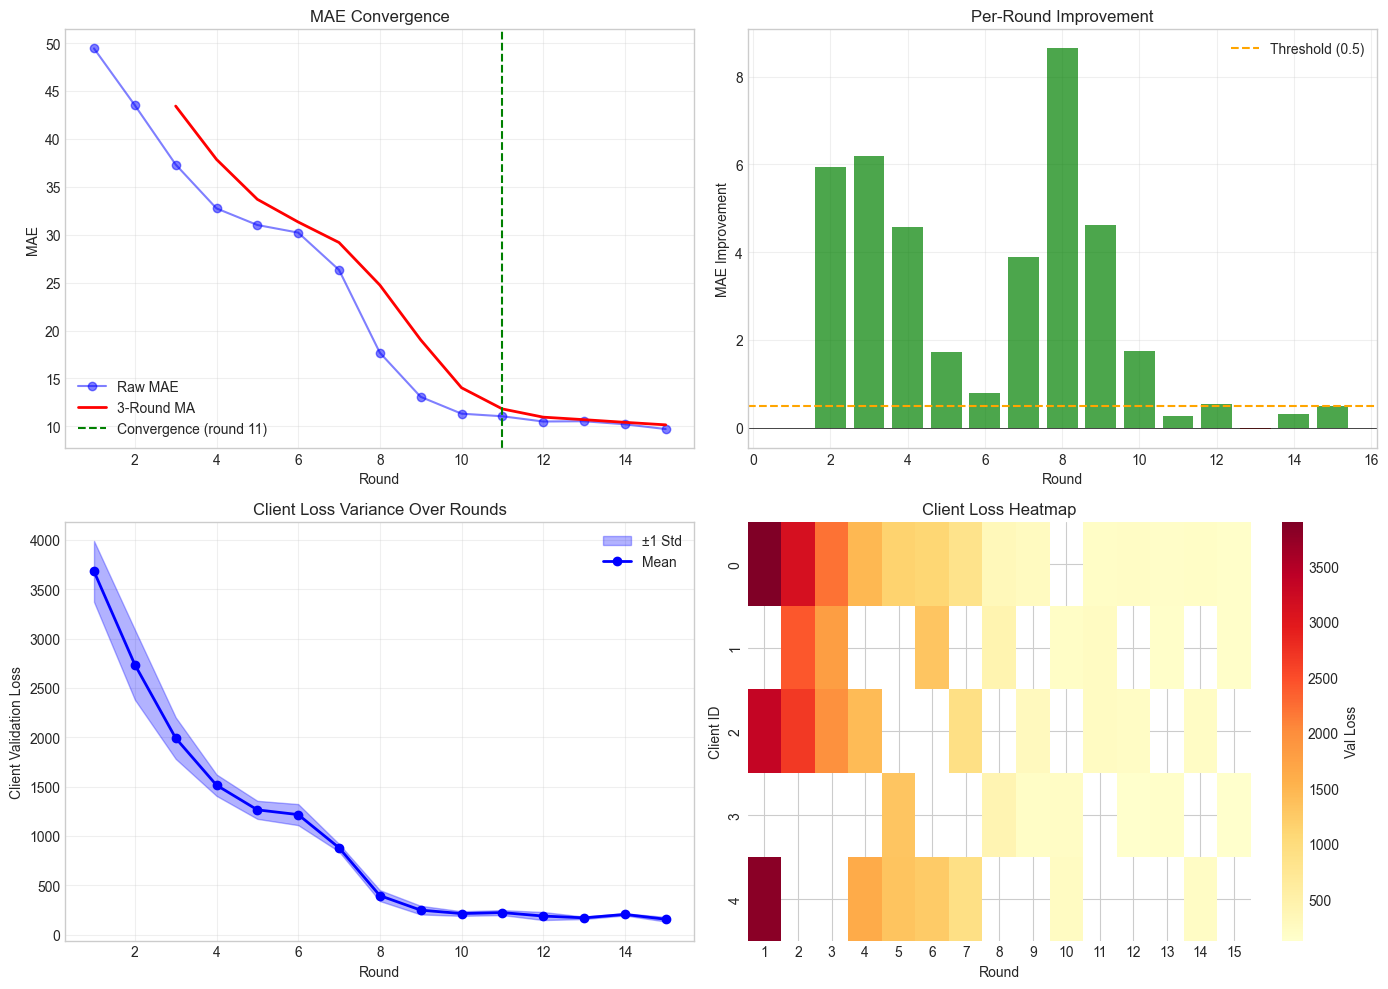

In [10]:
# Convergence visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE with moving average
ax1 = axes[0, 0]
ax1.plot(convergence_metrics['round_id'], convergence_metrics['global_mae'], 'b-o', 
         alpha=0.5, label='Raw MAE')
ax1.plot(convergence_metrics['round_id'], convergence_metrics['mae_ma'], 'r-', 
         linewidth=2, label=f'{window}-Round MA')
if converged_round:
    ax1.axvline(x=converged_round, color='g', linestyle='--', label=f'Convergence (round {converged_round})')
ax1.set_xlabel('Round')
ax1.set_ylabel('MAE')
ax1.set_title('MAE Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Improvement rate
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in convergence_metrics['mae_improvement'].fillna(0)]
ax2.bar(convergence_metrics['round_id'], convergence_metrics['mae_improvement'].fillna(0), color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold ({threshold})')
ax2.set_xlabel('Round')
ax2.set_ylabel('MAE Improvement')
ax2.set_title('Per-Round Improvement')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Client variance over rounds
ax3 = axes[1, 0]
client_variance = df_clients.groupby('round_id')['val_loss'].agg(['mean', 'std'])
ax3.fill_between(client_variance.index, 
                 client_variance['mean'] - client_variance['std'],
                 client_variance['mean'] + client_variance['std'],
                 alpha=0.3, color='blue', label='±1 Std')
ax3.plot(client_variance.index, client_variance['mean'], 'b-o', linewidth=2, label='Mean')
ax3.set_xlabel('Round')
ax3.set_ylabel('Client Validation Loss')
ax3.set_title('Client Loss Variance Over Rounds')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Learning curves heatmap
ax4 = axes[1, 1]
pivot_data = df_clients.pivot_table(values='val_loss', index='client_id', columns='round_id', aggfunc='mean')
sns.heatmap(pivot_data, ax=ax4, cmap='YlOrRd', annot=False, fmt='.2f', cbar_kws={'label': 'Val Loss'})
ax4.set_xlabel('Round')
ax4.set_ylabel('Client ID')
ax4.set_title('Client Loss Heatmap')

plt.tight_layout()
plt.savefig('../experiments/convergence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Detailed Client Analysis

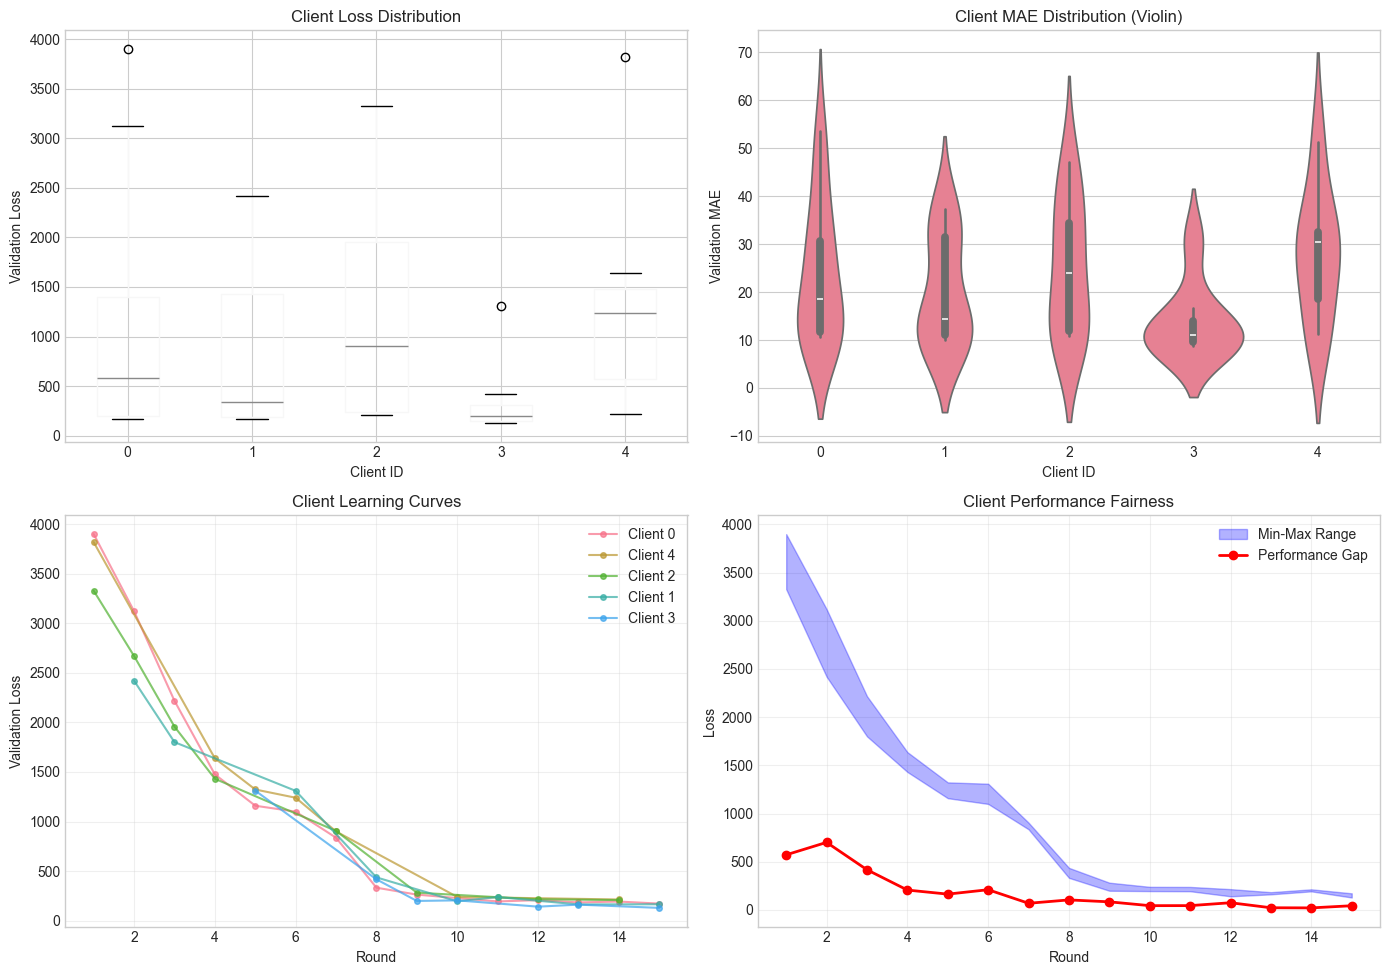

In [11]:
# Client contribution and fairness metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Box plot of client losses
ax1 = axes[0, 0]
df_clients.boxplot(column='val_loss', by='client_id', ax=ax1)
ax1.set_xlabel('Client ID')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Client Loss Distribution')
plt.suptitle('')  # Remove automatic title

# Violin plot
ax2 = axes[0, 1]
sns.violinplot(data=df_clients, x='client_id', y='val_mae', ax=ax2, inner='box')
ax2.set_xlabel('Client ID')
ax2.set_ylabel('Validation MAE')
ax2.set_title('Client MAE Distribution (Violin)')

# Client performance over time
ax3 = axes[1, 0]
for client_id in df_clients['client_id'].unique():
    client_df = df_clients[df_clients['client_id'] == client_id]
    ax3.plot(client_df['round_id'], client_df['val_loss'], '-o', 
             label=f'Client {client_id}', alpha=0.7, markersize=4)
ax3.set_xlabel('Round')
ax3.set_ylabel('Validation Loss')
ax3.set_title('Client Learning Curves')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Fairness: performance gap between best and worst clients
ax4 = axes[1, 1]
round_fairness = df_clients.groupby('round_id')['val_loss'].agg(['min', 'max', 'mean'])
round_fairness['gap'] = round_fairness['max'] - round_fairness['min']
ax4.fill_between(round_fairness.index, round_fairness['min'], round_fairness['max'], 
                  alpha=0.3, color='blue', label='Min-Max Range')
ax4.plot(round_fairness.index, round_fairness['gap'], 'r-o', linewidth=2, label='Performance Gap')
ax4.set_xlabel('Round')
ax4.set_ylabel('Loss')
ax4.set_title('Client Performance Fairness')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/client_detailed_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary Report

In [12]:
# Generate comprehensive summary
print('='*70)
print('FEDERATED LEARNING ANALYSIS REPORT')
print('='*70)

print('\n📊 PERFORMANCE SUMMARY')
print('-'*40)
print(f'Final Global MAE:  {df_rounds["global_mae"].iloc[-1]:.2f} cycles')
print(f'Best Global MAE:   {df_rounds["global_mae"].min():.2f} cycles (round {df_rounds["global_mae"].idxmin() + 1})')
print(f'Final Global RMSE: {df_rounds["global_rmse"].iloc[-1]:.2f} cycles')

print('\n🔒 PRIVACY ANALYSIS')
print('-'*40)
print(f'Final Privacy Budget (ε): {cumulative_epsilon:.4f}')
print(f'Delta (δ): {privacy_params["delta"]}')
print(f'Privacy Level: {"Strong" if cumulative_epsilon < 1 else "Moderate" if cumulative_epsilon < 10 else "Weak"}')

print('\n📈 CONVERGENCE ANALYSIS')
print('-'*40)
print(f'Total Rounds: {num_rounds}')
print(f'Estimated Convergence: Round {converged_round if converged_round else "Not converged"}')
print(f'Final Improvement Rate: {convergence_metrics["mae_improvement_pct"].iloc[-1]:.1f}%')

print('\n👥 CLIENT ANALYSIS')
print('-'*40)
print(f'Number of Clients: {df_clients["client_id"].nunique()}')
print(f'Best Performing Client: {df_clients.groupby("client_id")["val_mae"].mean().idxmin()}')
print(f'Client MAE Range: [{df_clients.groupby("client_id")["val_mae"].mean().min():.2f}, {df_clients.groupby("client_id")["val_mae"].mean().max():.2f}]')

print('\n📁 SAVED ARTIFACTS')
print('-'*40)
print('  - experiments/training_curves.png')
print('  - experiments/client_analysis.png')
print('  - experiments/baseline_comparison.png')
print('  - experiments/privacy_analysis.png')
print('  - experiments/weight_analysis.png')
print('  - experiments/convergence_analysis.png')
print('  - experiments/client_detailed_analysis.png')

print('\n' + '='*70)

FEDERATED LEARNING ANALYSIS REPORT

📊 PERFORMANCE SUMMARY
----------------------------------------
Final Global MAE:  9.72 cycles
Best Global MAE:   9.72 cycles (round 15)
Final Global RMSE: 12.61 cycles

🔒 PRIVACY ANALYSIS
----------------------------------------
Final Privacy Budget (ε): 16.1116
Delta (δ): 1e-05
Privacy Level: Weak

📈 CONVERGENCE ANALYSIS
----------------------------------------
Total Rounds: 15
Estimated Convergence: Round 11
Final Improvement Rate: 4.9%

👥 CLIENT ANALYSIS
----------------------------------------
Number of Clients: 5
Best Performing Client: 3
Client MAE Range: [13.97, 27.87]

📁 SAVED ARTIFACTS
----------------------------------------
  - experiments/training_curves.png
  - experiments/client_analysis.png
  - experiments/baseline_comparison.png
  - experiments/privacy_analysis.png
  - experiments/weight_analysis.png
  - experiments/convergence_analysis.png
  - experiments/client_detailed_analysis.png



In [ ]:
# Save analysis summary
analysis_summary = {
    'privacy': {
        'final_epsilon': cumulative_epsilon,
        'delta': privacy_params['delta'],
        'noise_multiplier': privacy_params['noise_multiplier'],
    },
    'convergence': {
        'converged_round': converged_round,
        'final_mae': float(df_rounds['global_mae'].iloc[-1]),
        'best_mae': float(df_rounds['global_mae'].min()),
    },
    'fairness': {
        'final_client_gap': float(round_fairness['gap'].iloc[-1]),
        'mean_client_gap': float(round_fairness['gap'].mean()),
    }
}

with open('../experiments/analysis_summary.json', 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print('Analysis summary saved to experiments/analysis_summary.json')